In [17]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
from code_comparison.solps_pp import *

from DLScommonTools import *


set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2

# Here are some useful labels to use for plotting throughout notebook
store_labels = dict()
store_labels["cvar"] = {"density" : "$n_{u}\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}$"}
store_labels["crel"] = {"density" : "$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ /\ q_{\parallel0} (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_names =         {"density" : "$n_{u}\ /\ n_{u0}$",
                        "power" : "$q_{\parallel0}\ /\ q_{\parallel}$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_cnames =         {"density" : "$[n_{u}\ /\ n_{u0}]^{1}$",
                        "power" : "$[q_{\parallel0}\ /\ q_{\parallel}]^{5/7}$",
                        "impurity_frac" : "$[f_{z}\ /\ f_{z0}]^{0.5}$"}


st40_phys_viewer can not be loaded from outside Tokamak Energy!

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read balance file

In [11]:
balance_path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
eqb = dict()
eqb["SPR45"] = dict()

for side in ["iu", "ou"]: # Inner upper, outer upper.
    eqb["SPR45"][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=1, resolution = 200)
    
    keys = list(eqb["SPR45"][side].keys())
    for key in keys:
        
        if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
            eqb["SPR45"][side].pop(key, None)
        
file_write(eqb, "equilibrium.pkl")

In [12]:
eqb = file_read("equilibrium.pkl")
data = eqb["SPR45"] # Pick design to use for study

In [36]:
import netCDF4 as nc
path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file"
ds = nc.Dataset(os.path.join(path, "balance.nc"))

leftix = ds["leftix"][:]+1
leftix_diff = np.diff(leftix[1,:])
xcut = np.argmin(leftix_diff - 1)

# print(leftix)
print(xcut)
# [print(x) for x in ds.variables.keys()]

ds.close()

13


In [37]:
np.diff(leftix[1,:])

masked_array(data=[  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
                     1,  99, -97,   1,   1,   1,   1,   1,   1,   1,   1,
                     1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
                     1,   1,   1,  51, -49,   1,   1,   1,   1,   1,   1,
                     1,   1,   1,   1,   1, -49,  51,   1,   1,   1,   1,
                     1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
                     1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
                     1,   1,   1,   1,   1,   1,   1,   1,   1, -49,  51,
                     1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
                     1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
                   -97,  99,   1,   1,   1,   1,   1,   1,   1,   1,   1,
                     1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
                     1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
                     1,   1,   1,   1]

In [22]:
self = SOLPScase(r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file")

# slc.plot_2d("ne", antialias = True)

NameError: name 'g' is not defined

In [ ]:
bal = self.bal = nc.Dataset(os.path.join(path, "balance.nc"))

# Check Btor contribution to Bx/Bt

In [10]:
R[0]

5.8035376175

In [14]:
d = eqb["SPR45"]["ou"]
Xpoint = d["Xpoint"]
Btot = d["Btot"]
Bpol = d["Bpol"]
R = d["R"]
Btor = np.sqrt(Btot**2 - Bpol**2)
S = d["S"]

exp_tot = Btot[Xpoint] / Btot[-2]
exp_pol = Bpol[Xpoint] / Bpol[-2]
exp_tor = Btor[Xpoint] / Btor[-2]
R_ratio = R[-1] / R[Xpoint]

print(f"Total expansion: {exp_tot:.2f}")
print(f"Poloidal expansion: {exp_pol:.2f}")
print(f"Toroidal expansion: {exp_tor:.2f}")
print(f"R ratio: {R_ratio:.2f}")

Total expansion: 1.87
Poloidal expansion: 0.02
Toroidal expansion: 2.28
R ratio: 2.27


# Check gradients

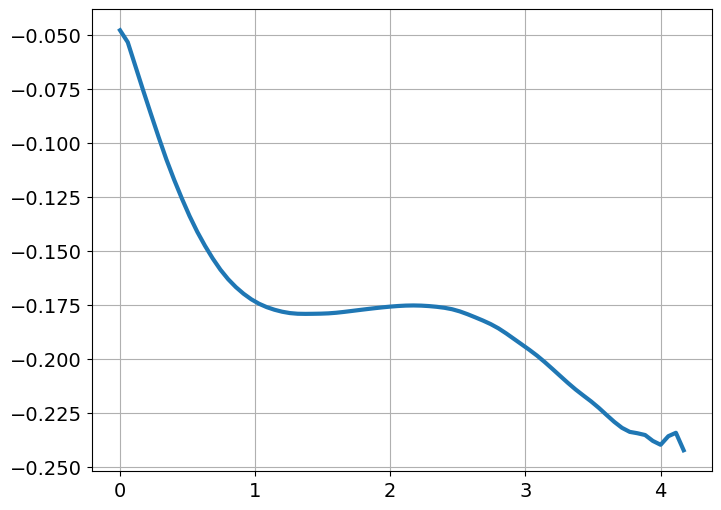

In [5]:
d = eqb["SPR45"]["ou"]
Xpoint = d["Xpoint"]
B = d["Btot"]
S = d["Spol"]
gradB = -np.gradient(B, S)
frac_gradB = gradB/B



plt.plot(S[:Xpoint], frac_gradB[:Xpoint])

# Plot profiles

## Parallel

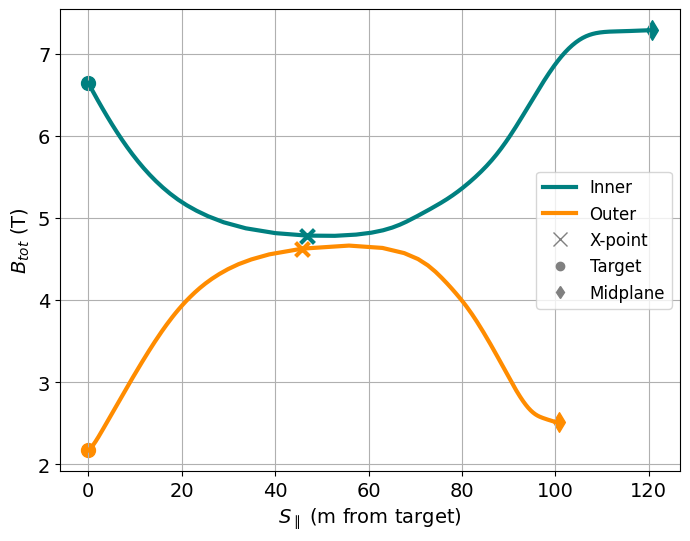

In [6]:
fig, ax = plt.subplots()
colors = mike_cmap(2)
labels = {"ou":"Outer", "iu":"Inner"}
size = 100

for i, side in enumerate(["iu", "ou"]):
    d = data[side]
    Xpoint = d["Xpoint"]
    ax.plot(d["S"], d["Btot"], color = colors[i], label = labels[side])
    ax.scatter(d["S"][Xpoint], d["Btot"][Xpoint], color = colors[i], marker = "x", s = size)
    ax.scatter(d["S"][0], d["Btot"][0], color = colors[i], marker = "o", s = size)
    ax.scatter(d["S"][-1], d["Btot"][-1], color = colors[i], marker = "d", s = size)

ax.set_xlabel("$S_{\parallel}$ (m from target)")
ax.set_ylabel("$B_{tot}$ (T)")
ax.legend()

h,l = ax.get_legend_handles_labels()
extra_handles = [
    mpl.lines.Line2D([0], [0], color = "grey", marker = "x", linewidth=0, label = "X-point", markersize = 10),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Target"),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "d", linewidth=0, label = "Midplane")]

ax.legend(fontsize = 12, handles = h+extra_handles)

## Poloidal

In [13]:
d.keys()

dict_keys(['Bpol', 'Btot', 'R', 'Z', 'Xpoint', 'Spol', 'S'])

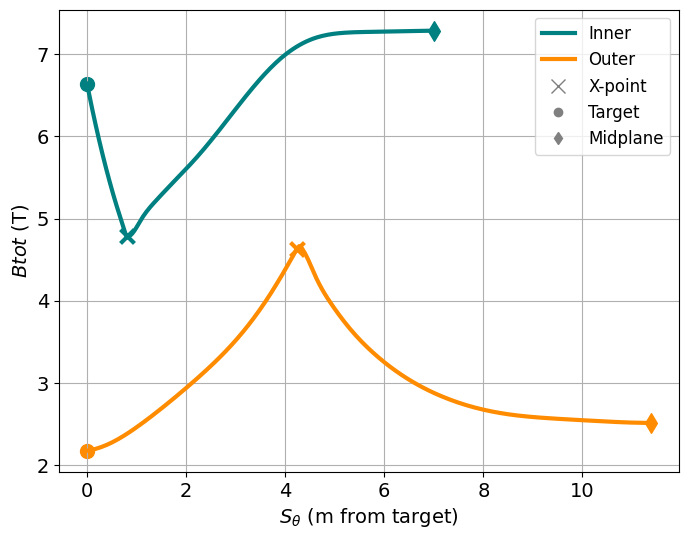

In [14]:
fig, ax = plt.subplots()
colors = mike_cmap(2)
labels = {"ou":"Outer", "iu":"Inner"}
size = 100
param = "Btot"
for i, side in enumerate(["iu", "ou"]):
    d = data[side]
    Xpoint = d["Xpoint"]
    ax.plot(d["Spol"], d[param], color = colors[i], label = labels[side])
    ax.scatter(d["Spol"][Xpoint], d[param][Xpoint], color = colors[i], marker = "x", s = size)
    ax.scatter(d["Spol"][0], d[param][0], color = colors[i], marker = "o", s = size)
    ax.scatter(d["Spol"][-1], d[param][-1], color = colors[i], marker = "d", s = size)

ax.set_xlabel(r"$S_{\theta}$ (m from target)")
ax.set_ylabel(f"${param}$ (T)")
ax.legend()

h,l = ax.get_legend_handles_labels()
extra_handles = [
    mpl.lines.Line2D([0], [0], color = "grey", marker = "x", linewidth=0, label = "X-point", markersize = 10),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Target"),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "d", linewidth=0, label = "Midplane")]

ax.legend(fontsize = 12, handles = h+extra_handles)

In [11]:
pol_exp = d["Bpol"][0] / d["Bpol"][Xpoint]

print(pol_exp)

21.985799019240766


# Setup and run DLS

In [6]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

In [52]:
cvar = "density"
design = "SPR45"
side = "ou"

store = dict()
# for cvar in ["power"]:
for cvar in ["density", "impurity_frac", "power"]:
    store[cvar] = dict()
    
    for side in ["iu", "ou"]:
    # for side in ["iu"]:
        d = eqb[design][side].copy() # Load in single profile into dictionary "d"
        constants = constants_default.copy() # Set settings to default
        radios = radios_default.copy() # Set settings to default
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 100) # Solve at these parallel positions

        if side == "iu":
            constants["qpllu0"] = constants_default["qpllu0"] * 1.1 # Reduce power to 10% for the inner divertor to account for power sharing.

        results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-5, Ttol=1e-5)
        
        store[cvar][side] = copy.deepcopy(results)

Solving...0...2...5...7...9...12...14...16...19...21...23...25...28...30...32...34...37...39...41...43...45...47...49...51...53...55...57...59...61...63...64...66...68...69...71...73...74...76...77...79...80...81...83...84...85...86...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...Complete in 149.0 seconds
Solving...0...16...31...44...56...68...78...89...99...108...118...127...136...145...153...162...170...178...187...195...202...210...217...224...231...238...245...251...257...262...268...273...278...283...287...292...296...300...303...307...310...313...316...319...322...325...327...330...332...334...336...338...340...342...344...345...347...348...350...351...352...353...355...356...357...358...359...360...361...362...363...364...365...366...367...368...369...370...371...372...373...374...375...Complete in 168.1 seconds
Solving...0...2...5...7...9...12...14...16...19

C:\Users\mikek\OneDrive\Project\DLS\DLS-git\LRBv21.py:63: RuntimeWarning: invalid value encountered in scalar power
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Complete in 158.1 seconds
Solving...0...16...31...44...56...68...78...89...99...108...118...127...136...145...153...162...170...178...187...195...202...210...217...224...231...238...245...251...257...262...268...273...278...283...287...292...296...300...303...307...310...313...316...319...322...325...327...330...332...334...336...338...340...342...344...345...347...348...350...351...352...353...355...356...357...358...359...360...361...362...363...364...365...366...367...368...369...370...371...372...373...374...375...Complete in 153.9 seconds


In [53]:
file_write(store, "spr45_full.pkl")

In [60]:
store = file_read("spr45_full.pkl")

# Plot basic results

In [54]:
o.keys()

dict_keys(['Splot', 'SpolPlot', 'cvar', 'Tprofiles', 'Sprofiles', 'Qprofiles', 'Rprofiles', 'logs', 'splot', 'indexRange', 'crel', 'cvar_trim', 'crel_trim', 'threshold', 'window', 'window_ratio', 'spar_onset', 'spol_onset', 'constants', 'radios'])

Text(0.5, 1.0, 'Inner divertor')

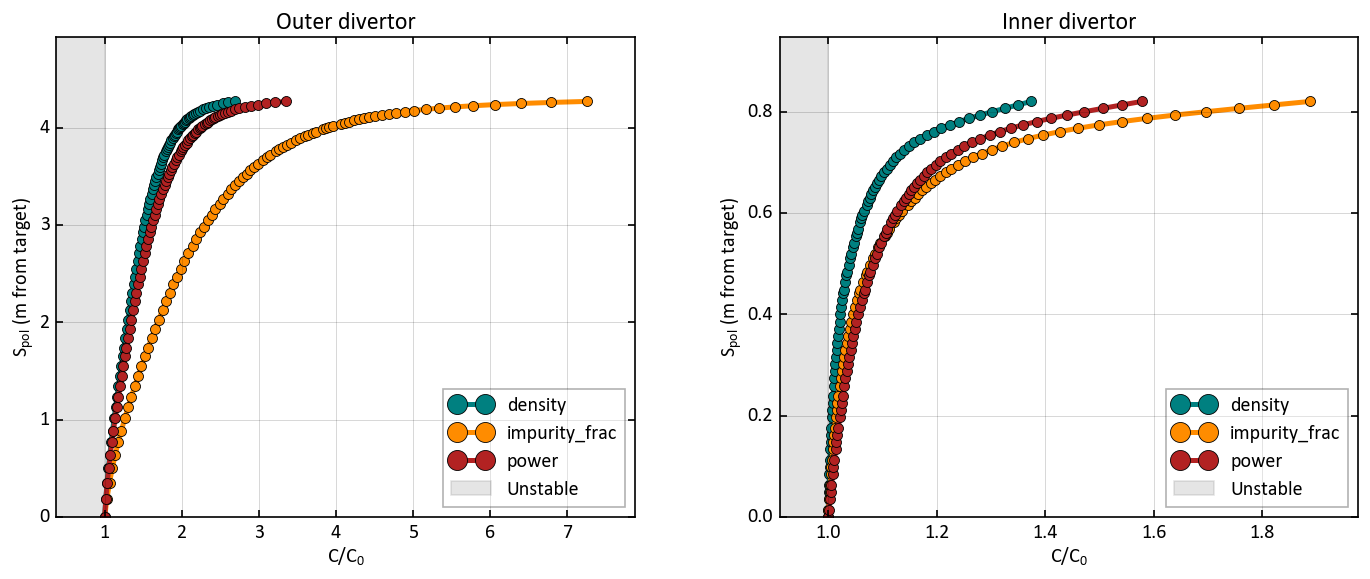

In [8]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(4)
cvar = "impurity_frac"
fig, axes = plt.subplots(1,2, figsize = (14,5))
# fig.suptitle("Density scan of front profiles")
ax = axes[0]

basis = "crel"

for k, side in enumerate(["ou", "iu"]):


    for i, cvar in enumerate(["density", "impurity_frac", "power"]):
        
        o = store[cvar][side].copy()
        x = o[basis]        
        if cvar == "power":
            x = 1/x
        axes[k].plot(x, o["SpolPlot"],  marker = "o", markersize = 6, linewidth = 3,  color = colors[i], label = cvar)


for ax in axes:
    
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    
    ylims = ax.get_ylim()
    ylims_new = (0,ylims[1]+ylims[1]*0.05)
    ax.set_ylim(ylims_new)
    ax.fill_between([xlims[0],1],0,ylims_new[1], color = "grey", alpha = 0.2, label = "Unstable")   
    ax.set_xlim(xlims)
    
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$C/C_{0}$")
    # ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.legend(fontsize = 12)
    # ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")

# Safety margin

In [141]:
2.8 / 3

0.9333333333333332

In [27]:
store.keys()

dict_keys(['density', 'impurity_frac', 'power'])

In [196]:
store[]

array([-1.        , -0.91115312, -0.81285444, -0.72022684, -0.62759924,
       -0.536862  , -0.45179584, -0.36672968, -0.28355388, -0.21172023,
       -0.13610586, -0.05293006,  0.01512287,  0.10586011,  0.1852552 ,
        0.27221172,  0.35538752,  0.46502836,  0.60869565,  0.69187146])

In [195]:
crel

array([-1.        , -0.91115312, -0.81285444, -0.72022684, -0.62759924,
       -0.536862  , -0.45179584, -0.36672968, -0.28355388, -0.21172023,
       -0.13610586, -0.05293006,  0.01512287,  0.10586011,  0.1852552 ,
        0.27221172,  0.35538752,  0.46502836,  0.60869565,  0.69187146])

(-0.1, 0.5)

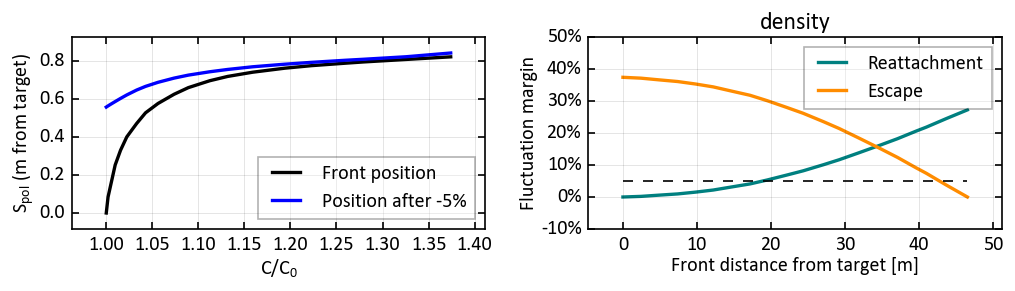

In [270]:
plt.style.use(r"C:\Users\mikek\OneDrive\Project\python-packages\matplotlib_styles\mike.mplstyle")
side = "iu"
cvar = "density"

o = store[cvar][side].copy()
d = eqb["SPR45"][side].copy()
# crel = o["cvar"]
crel = 1/o["crel"] if cvar == "power" else o["crel"]
# crel -= 1

base_spol = interpolate.interp1d(crel, o["SpolPlot"], kind = "cubic")
negative_spol = interpolate.interp1d(crel-0.05, o["SpolPlot"], fill_value="extrapolate", kind = "cubic")

negative = [negative_spol(x) for x in crel]

fig, axes = plt.subplots(1,2, figsize = (10,2), dpi = 120)
ax = axes[0]
ax.plot(crel, o["SpolPlot"], color = "black", label = "Front position")
# ax.plot(o["crel"], [base_spol(x) for x in o["crel"]], color = "black", label = "Front position")
ax.plot(crel, negative, label = "Position after -5%", color = "blue")
# ax.plot(o["crel"]+0.05, o["SpolPlot"], label = "Position after +5%", color = "red")
ax.set_xlabel("$C / C_{0}$")
ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
ax.legend()


ax = axes[1]

# dashes = ["solid", "dashed", "dashdot"]
# for i, cvar in enumerate(["density", "impurity_frac", "power"]):
# o = store[cvar]["ou"]

margin1 = abs((crel[0] - crel)/crel)
margin2 = abs((crel[-1] - crel)/crel)

x = o["Splot"]
ax.plot(x, margin1, label = "Reattachment", ls = dashes[i])
ax.plot(x, margin2, label = "Escape", ls = dashes[i])
# ax.plot((crel[-1] - crel)/crel, o["SpolPlot"], color = "black", label = "Allowable cvar increase before escape")

ax.hlines(0.05, x[0], x[-1], colors = "k", lw = 1, ls = "--")

ax.legend()
ax.set_title(f"{cvar}")
ax.set_xlabel("Front distance from target [m]")
ax.set_ylabel("Fluctuation margin")
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_ylim(-0.1,0.5)

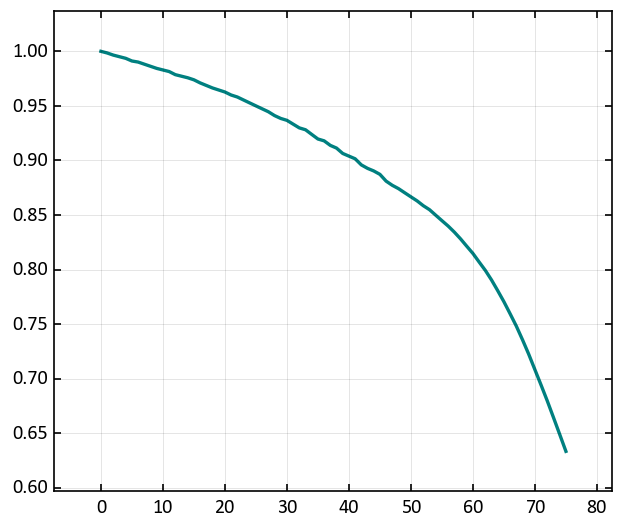

In [334]:
plt.plot(o["crel"])

In [ ]:
ax

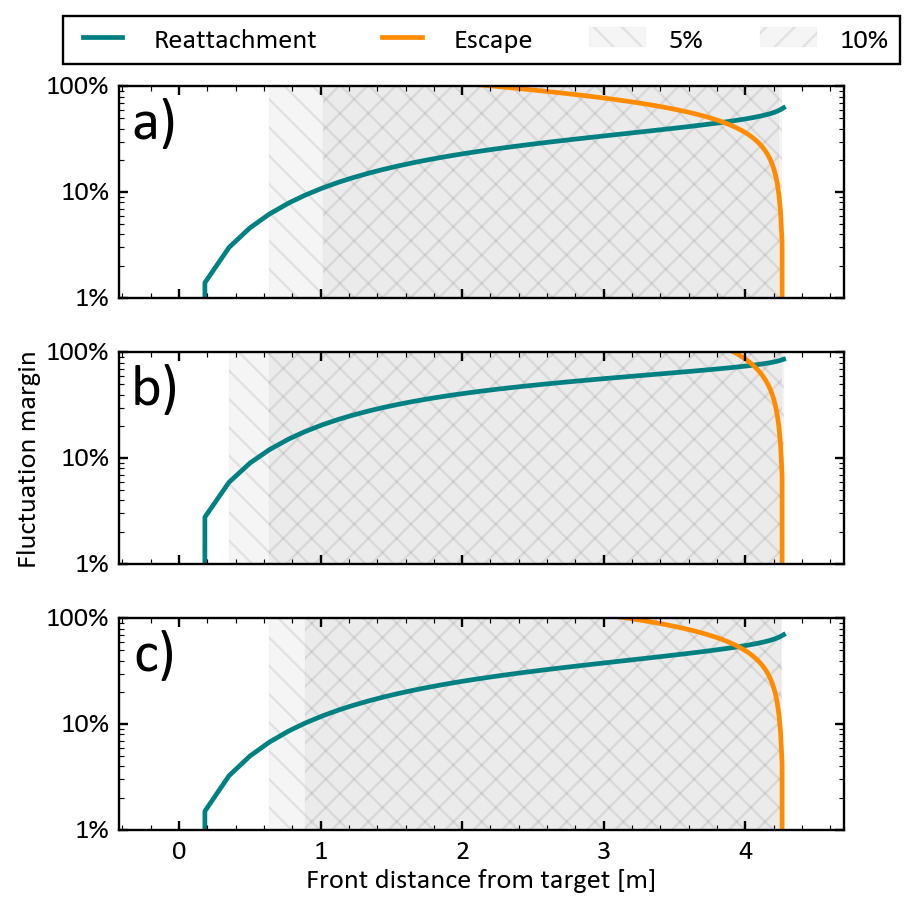

In [9]:
plt.style.use(r"C:\Users\mikek\OneDrive\Project\python-packages\matplotlib_styles\mike.mplstyle")
side = "ou"
cvar = "density"

o = store[cvar][side].copy()
d = eqb["SPR45"][side].copy()

edges = {}

fig, axes = plt.subplots(3,1, figsize = (5,5), dpi = 170, sharex = True)

fig.subplots_adjust(hspace=0)
fig.tight_layout()

# dashes = ["solid", "dashed", "dashdot"]
titles = ["a)", "b)", "c)"]
for i, cvar in enumerate(["density", "impurity_frac", "power"]):
    o = store[cvar][side]
    crel = 1/o["crel"] if cvar == "power" else o["crel"]
    ax = axes[i]
    margin1 = abs((crel[0] - crel)/crel)
    margin2 = abs((crel[-1] - crel)/crel)

    x = o["SpolPlot"]; ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    # x = o["Splot"]; ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.plot(x, margin1, label = "Reattachment")
    ax.plot(x, margin2, label = "Escape")
    # ax.plot((crel[-1] - crel)/crel, o["SpolPlot"], color = "black", label = "Allowable cvar increase before escape")

    # ax.hlines(0.05, x[0], x[-1]*1.05, colors = "r", lw = 2, ls = "-", label = "5% fluctuation")
    start1 = np.where(margin1 > 0.05)[0][0]
    end1  = np.where(margin2 < 0.05)[0][0]
    start2 = np.where(margin1 > 0.10)[0][0]
    end2 = np.where(margin2 < 0.10)[0][0]
    
    ax.fill_between(
        [x[start1],
         x[end1]], 
                    y1 = 1e-3, y2 = 2, color = "grey", alpha = 0.08, label = "5%", hatch = "\\\\", edgecolor = "k", linewidth = 0.1)
    
    ax.fill_between(
        [x[start2],
         x[end2]], 
                    y1 = 1e-3, y2 = 2, color = "grey", alpha = 0.08, label = "10%", hatch = "//", edgecolor = "k", linewidth = 0.1)


    if i == 0: ax.legend(loc="upper center", ncols=4, framealpha = 1, bbox_to_anchor=(0.5, 1.4))
    ax.set_title(titles[i], y=0.70, x = 0.05, fontsize = 25)
    if i == 2: ax.set_xlabel("Front distance from target [m]")
    if i == 1: ax.set_ylabel("Fluctuation margin")
    
    
    ax.grid(which="minor", c = "k", alpha = 0.1, lw = 0.5)
    ax.grid(which="major", c = "k", alpha = 0.4, lw = 0.5)
    ax.grid(which="both", alpha = 0)
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))

    ax.set_ylim(0.01,1)
    # ax.set_ylim(-0.1,1.1)
    

density, 0.70
power, 0.63
impurity_frac, 0.38


Text(0, 0.5, 'Band width (m poloidal)')

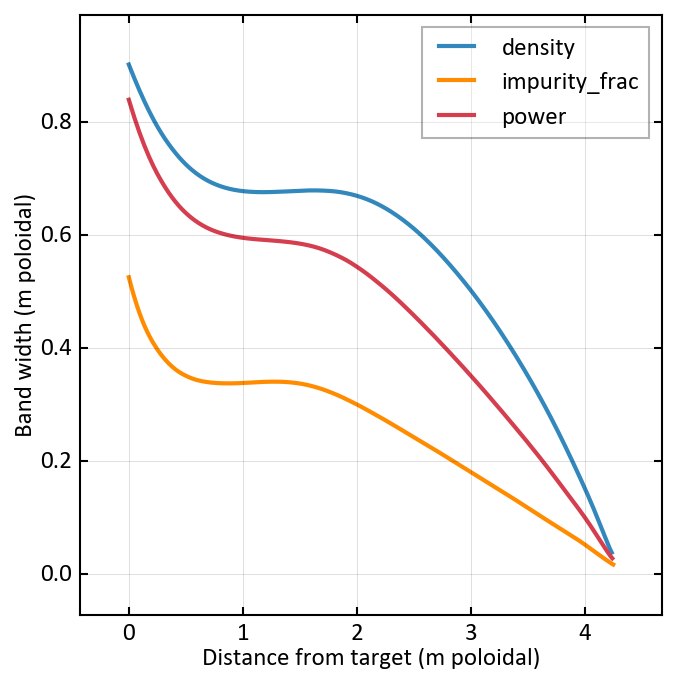

In [71]:
band_widths = {}
size = 0.05
side = "ou"
for cvar in ["power", "impurity_frac", "density"]:
    d = eqb["SPR45"][side]
    o = store[cvar][side]
    
    # Find first valid index
    # This trims the unstable region on the inner
    # trim_idx = 0
    # for i,_ in enumerate(o["cvar_trim"]):
    #     if pd.isnull(o["cvar_trim"][i]) and not pd.isnull(o["cvar_trim"][i+1]):
    #         trim_idx = i+1
        
    # Make band based on topology dictionary (d) and results dictionary (o)
    # and a desired S poloidal location of the band centre (spol_middle)
    # as well as band size as a fraction (default +/-5%)
    trim_idx = 0
    crel = np.array(o["crel"])[trim_idx:]
    splot = np.array(o["Splot"])[trim_idx:]
    spolplot = np.array(o["SpolPlot"])[trim_idx:]

    if cvar == "power":
        crel = 1/crel

    c_grid = np.linspace(crel[0], crel[-1], 1000)
    k = 5
    spar_interp = interpolate.interp1d(crel, splot, kind="cubic", fill_value = "extrapolate")
    spol_interp = interpolate.interp1d(crel, spolplot, kind="cubic", fill_value = "extrapolate")

    band_widths[cvar] = []
    for i, c_start in enumerate(c_grid):
        c_middle = c_start/(1-size)
        c_end = c_middle*(1+size)

        spar_start = spar_interp(c_start)
        spar_middle = spar_interp(c_middle)
        spar_end = spar_interp(c_end)

        spol_start = spol_interp(c_start)
        spol_middle = spol_interp(c_middle)
        spol_end = spol_interp(c_end)

        # band_widths.append(s_end - s_start)
        # band_widths.append(interp(c_start/(1-size)*(1+size)) - interp(c_start))
        band_width = spol_end - spol_start
        # band_width = spar_end - spar_start

        if band_width <= 0:
            band_widths[cvar].append(np.nan)
        elif spol_end > spolplot[-1]:
            band_widths[cvar].append(np.nan)
        else:
            band_widths[cvar].append(band_width)



fig, ax = plt.subplots(figsize=(5,5), dpi = 150)
x = spol_interp(c_grid)
ax.plot(x, band_widths["density"], label = "density", color = "#3288bd")
ax.plot(x, band_widths["impurity_frac"], label = "impurity_frac", color = "darkorange")
ax.plot(x, band_widths["power"], label = "power", color = "#d53e4f")

for cvar in ["density", "power", "impurity_frac"]:
    for i, _ in enumerate(x):
        if x[i] > band_widths[cvar][i]:
            idx = i
            print(f"{cvar}, {x[i]:.2f}")
            break
    # ax.scatter(x[i], band_widths[cvar][i], marker = "x", c = "k", s = 100, zorder = 100)


ax.legend(fontsize = 12)
ax.set_xlabel("Distance from target (m poloidal)")
ax.set_ylabel("Band width (m poloidal)")
    # band_width(2, interp)

density, 0.70
power, 0.63
impurity_frac, 0.38


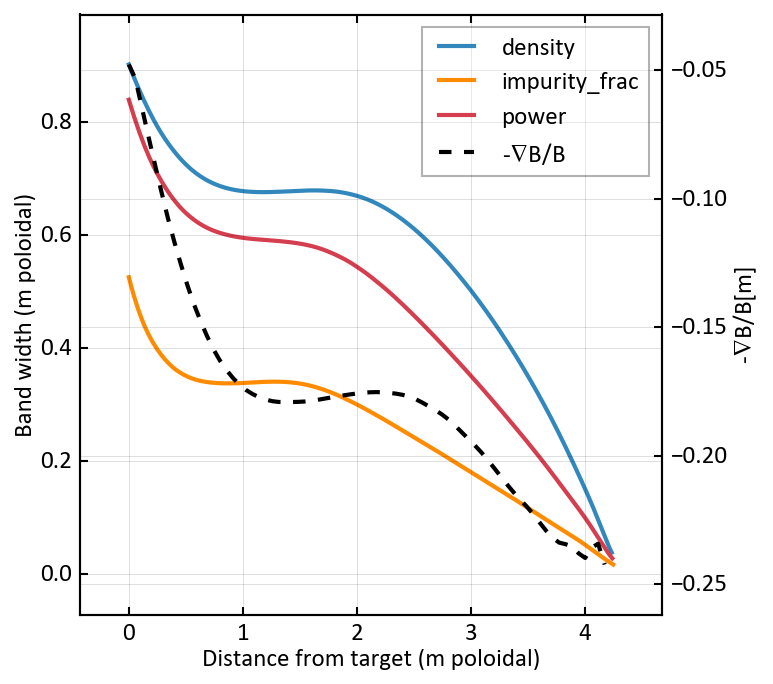

In [72]:

# d = eqb["SPR45"]["ou"]
Xpoint = d["Xpoint"]
B = d["Btot"]
S = d["Spol"]
gradB = -np.gradient(B, S)
frac_gradB = gradB/B



fig, ax = plt.subplots(figsize=(5,5), dpi = 150)
x = spol_interp(c_grid)
ax.plot(x, band_widths["density"], label = "density", color = "#3288bd")
ax.plot(x, band_widths["impurity_frac"], label = "impurity_frac", color = "darkorange")
ax.plot(x, band_widths["power"], label = "power", color = "#d53e4f")

for cvar in ["density", "power", "impurity_frac"]:
    for i, _ in enumerate(x):
        if x[i] > band_widths[cvar][i]:
            idx = i
            print(f"{cvar}, {x[i]:.2f}")
            break
    # ax.scatter(x[i], band_widths[cvar][i], marker = "x", c = "k", s = 100, zorder = 100)



ax.set_xlabel("Distance from target (m poloidal)")
ax.set_ylabel("Band width (m poloidal)")

ax2 = ax.twinx()
ax2.plot(d["Spol"][:Xpoint],frac_gradB[:Xpoint], label = "-$\\nabla B / B$", color = "k", ls = "--")
ax2.set_ylabel("-$\\nabla B / B [m]$")

fig.legend(fontsize = 12, loc = "upper right", bbox_to_anchor=(0.9,0.9))

In [377]:
np.where(margin2 < 0.05)

(array([73, 74, 75], dtype=int64),)

In [374]:
np.where(margin2 > 0.95)[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [371]:
end1 = np.where(margin1 > 0.05)[0][0]
end1

26

In [212]:
1/2.7

0.37037037037037035

In [214]:
i = 0
crel = store["density"]["ou"]["cvar"]
# escape = ((crel[-1] - crel[i])/crel[i])
escape = (crel[-1] - crel[i])/crel[i]

print(f"Pos: {o['SpolPlot'][i]:.1f}, Crel: {crel[i]:.1f}")
print(f"Crel distance to escape: {crel[-1]-crel[i]:.1f}")
print(f"Crel ratio to escape: {crel[-1]/crel[i]:.1f}")
print(f"Fluctuation to escape: +{escape:.0%}")

Pos: 0.0, Crel: 51660156249999998976.0
Crel distance to escape: 87402343750000001024.0
Crel ratio to escape: 2.7
Fluctuation to escape: +169%


In [202]:
crel[-1]/crel[0]

1.374031007751938

In [203]:
o = store["density"]["ou"].copy()

o["crel"]

array([1.        , 1.08884688, 1.18714556, 1.27977316, 1.37240076,
       1.463138  , 1.54820416, 1.63327032, 1.71644612, 1.78827977,
       1.86389414, 1.94706994, 2.01512287, 2.10586011, 2.1852552 ,
       2.27221172, 2.35538752, 2.46502836, 2.60869565, 2.69187146])

In [204]:
o["cvar"] / o["cvar"][0]

array([1.        , 1.08884688, 1.18714556, 1.27977316, 1.37240076,
       1.463138  , 1.54820416, 1.63327032, 1.71644612, 1.78827977,
       1.86389414, 1.94706994, 2.01512287, 2.10586011, 2.1852552 ,
       2.27221172, 2.35538752, 2.46502836, 2.60869565, 2.69187146])

# Read detachment bands

## Band function

In [36]:
# def make_window_band(d, o, spol_middle, size = 0.05):
    
side = "iu"
cvar = "density"
d = eqb["SPR45"][side]
o = store[cvar][side]
spol_middle = 3

# Find first valid index
for i,_ in enumerate(o["cvar_trim"]):
    if pd.isnull(o["cvar_trim"][i]) and not pd.isnull(o["cvar_trim"][i+1]):
        trim_idx = i
    
# Make band based on topology dictionary (d) and results dictionary (o)
# and a desired S poloidal location of the band centre (spol_middle)
# as well as band size as a fraction (default +/-5%)

crel = np.array(o["crel"])[trim_idx:]
splot = np.array(o["Splot"])[trim_idx:]
spolplot = np.array(o["SpolPlot"])[trim_idx:]
Btot = d["Btot"]
Btot_grad = np.gradient(Btot)

c_grid = np.linspace(crel[0], crel[-1], 1000)

In [38]:

# Need continuous functions for the front locations and corresponding control variables.
spar_from_crel = interpolate.UnivariateSpline(crel, splot, k= 5)
spol_from_crel = interpolate.UnivariateSpline(crel, spolplot, k= 5)
crel_from_spol = interpolate.UnivariateSpline(spolplot, crel, k= 5)

In [40]:



c_middle = crel_from_spol(spol_middle)

# Band control variable for middle and both ends.
band = dict()
band["C"] = [None] * 3
band["C"][0] = c_middle * (1-size)
band["C"][1] = c_middle
band["C"][2] = c_middle * (1+size)

# The dictionary "band" contains several parameters. Each parameter contains a list of three 
# values corresponding to the three points of the band. In this way band["Btot"] has a list of the
# total B values across the band.
for param in ["Spar", "Spol", "index", "R", "Z", "Btot"]:
    band[param] = np.array([float]*3)

for i in range(3):
    band["Spar"][i] = spar_from_crel(band["C"][i])    
    band["Spol"][i] = spol_from_crel(band["C"][i])
    band["index"][i] = np.argmin(np.abs(d["S"] - band["Spar"][i]))
    band["R"][i] = d["R"][band["index"][i]]
    band["Z"][i] = d["Z"][band["index"][i]]
    band["Btot"][i] = d["Btot"][band["index"][i]]
    
band["width_pol"] = band["Spol"][2] - band["Spol"][0] # Band width in poloidal
band["width_par"] = band["Spar"][2] - band["Spar"][0] # Band width in parallel
band["Btot_avg"] = np.mean(Btot[band["index"][0]:band["index"][2]])
band["Btot_grad_avg"] = np.mean(Btot_grad[band["index"][0]:band["index"][2]])

# return band

In [57]:
def make_window_band(d, o, spol_middle, size = 0.05):
    # Find first valid index
    # This trims the unstable region on the inner
    trim_idx = 0
    for i,_ in enumerate(o["cvar_trim"]):
        if pd.isnull(o["cvar_trim"][i]) and not pd.isnull(o["cvar_trim"][i+1]):
            trim_idx = i
        
    # Make band based on topology dictionary (d) and results dictionary (o)
    # and a desired S poloidal location of the band centre (spol_middle)
    # as well as band size as a fraction (default +/-5%)

    crel = np.array(o["crel"])[trim_idx:]
    splot = np.array(o["Splot"])[trim_idx:]
    spolplot = np.array(o["SpolPlot"])[trim_idx:]

    
    if spol_middle < spolplot[0] or spol_middle > spolplot[-1]:
        raise ValueError(f"spol_middle is {spol_middle:.2f} outside of valid range. Must be within {spolplot[0]:.2f} - {spolplot[-1]:.2f}")
    
    Btot = d["Btot"]
    Btot_grad = np.gradient(Btot)

    c_grid = np.linspace(crel[0], crel[-1], 1000)

    # Need continuous functions for the front locations and corresponding control variables.
    spar_from_crel = interpolate.UnivariateSpline(crel, splot, k= 5)
    spol_from_crel = interpolate.UnivariateSpline(crel, spolplot, k= 5)
    crel_from_spol = interpolate.UnivariateSpline(spolplot, crel, k= 5)

    c_middle = crel_from_spol(spol_middle)
    
    # Band control variable for middle and both ends.
    band = dict()
    band["C"] = [None] * 3
    band["C"][0] = c_middle * (1-size)
    band["C"][1] = c_middle
    band["C"][2] = c_middle * (1+size)

    # The dictionary "band" contains several parameters. Each parameter contains a list of three 
    # values corresponding to the three points of the band. In this way band["Btot"] has a list of the
    # total B values across the band.
    for param in ["Spar", "Spol", "index", "R", "Z", "Btot"]:
        band[param] = np.array([float]*3)

    for i in range(3):
        band["Spar"][i] = spar_from_crel(band["C"][i])    
        band["Spol"][i] = spol_from_crel(band["C"][i])
        band["index"][i] = np.argmin(np.abs(d["S"] - band["Spar"][i]))
        band["R"][i] = d["R"][band["index"][i]]
        band["Z"][i] = d["Z"][band["index"][i]]
        band["Btot"][i] = d["Btot"][band["index"][i]]
        
    band["width_pol"] = band["Spol"][2] - band["Spol"][0] # Band width in poloidal
    band["width_par"] = band["Spar"][2] - band["Spar"][0] # Band width in parallel
    band["Btot_avg"] = np.mean(Btot[band["index"][0]:band["index"][2]])
    band["Btot_grad_avg"] = np.mean(Btot_grad[band["index"][0]:band["index"][2]])

    return band

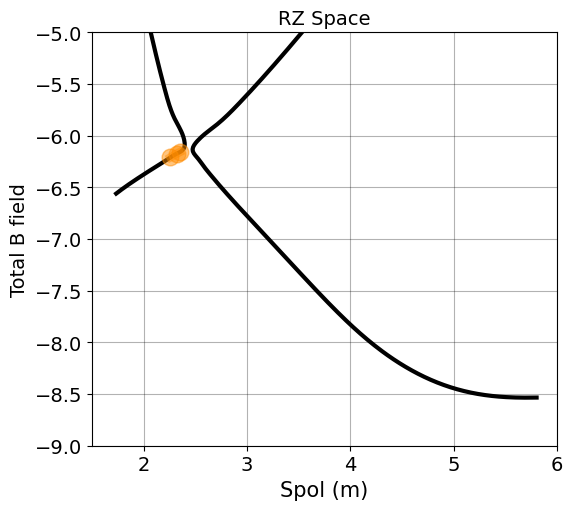

In [25]:
fig, ax = plt.subplots(1, figsize = (6,12))
k = 6
side = "iu"
cvar = "power"
d = eqb["SPR45"][side]
d_inner = eqb["SPR45"]["iu"]
d_outer = eqb["SPR45"]["ou"]
o = store[cvar][side]
spol1 = 0.7
if cvar == "power":
    o["crel"] = 1/o["crel"]

band = make_window_band(d, o, 0.5) # Make band at 3m

ax.plot(d_inner["R"], d_inner["Z"]*-1, linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.plot(d_outer["R"], d_outer["Z"]*-1, linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-9, -5)
ax.set_xlim(1.5,6)

alpha = 0.5
ax.set_title("RZ Space")
ax.plot(make_window_band(d, o, spol1)["R"], make_window_band(d, o, spol1)["Z"]*-1, markersize = 12, marker = "o", linewidth = 6, color = "darkorange", alpha = alpha)
ax.plot(d["Spol"], d["Btot"]); 
ax.set_xlabel("Spol (m)"); ax.set_ylabel("Total B field")
ax.grid(alpha = 0.3, color = "k")
ax.set_aspect("equal")

## Compute bands

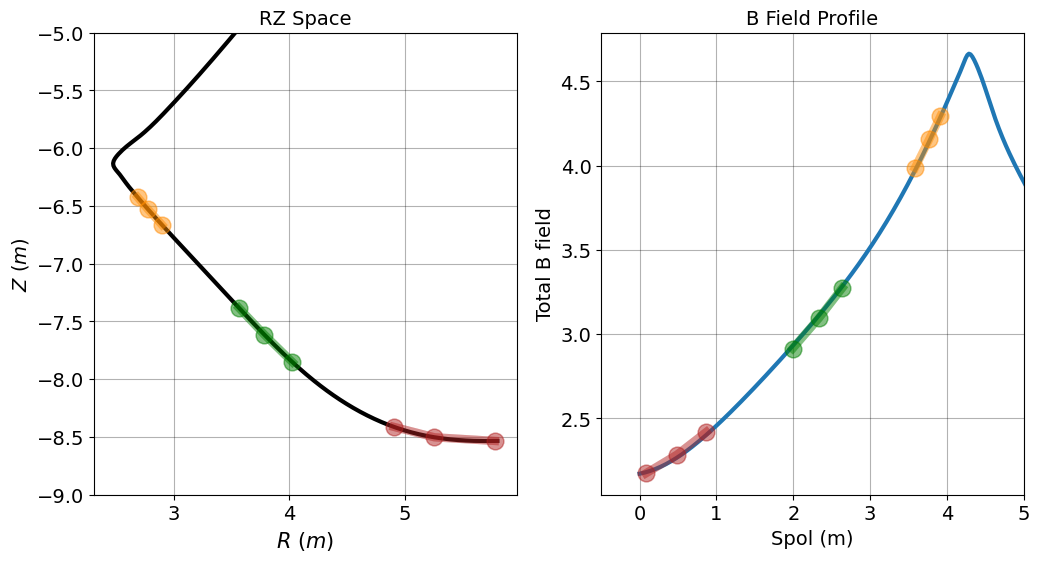

In [10]:
fig, axes = plt.subplots(1,2, figsize = (12,6))
k = 6
side = "ou"
cvar = "density"
d = eqb["SPR45"][side]
o = store[cvar][side]

band = make_window_band(d, o, 1) # Make band at 3m

ax = axes[0]
ax.plot(d["R"], d["Z"]*-1, label = "Morph factor 1".format(side), linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-9, -5)

ax.set_title("RZ Space")
color = "red"

spol1 = 3.8
spol2 = 2.2
spol3 = 0.2
alpha = 0.2

for point in range(3):
    ax.plot(make_window_band(d, o, spol1)["R"], make_window_band(d, o, spol1)["Z"]*-1, markersize = 12, marker = "o", linewidth = 6, color = "darkorange", alpha = alpha)
    ax.plot(make_window_band(d, o, spol2)["R"], make_window_band(d, o, spol2)["Z"]*-1, markersize = 12, marker = "o", linewidth = 6, color = "green", alpha = alpha)
    ax.plot(make_window_band(d, o, spol3)["R"], make_window_band(d, o, spol3)["Z"]*-1, markersize = 12, marker = "o", linewidth = 6, color = "firebrick", alpha = alpha)

ax = axes[1]
ax.plot(d["Spol"], d["Btot"]); 
ax.set_xlabel("Spol (m)"); ax.set_ylabel("Total B field")

for point in range(3):
    ax.plot(make_window_band(d, o, spol1)["Spol"], make_window_band(d, o, spol1)["Btot"], markersize = 12, marker = "o", linewidth = 6, color = "darkorange", alpha = alpha)
    ax.plot(make_window_band(d, o, spol2)["Spol"], make_window_band(d, o, spol2)["Btot"], markersize = 12, marker = "o", linewidth = 6, color = "green", alpha = alpha)
    ax.plot(make_window_band(d, o, spol3)["Spol"], make_window_band(d, o, spol3)["Btot"], markersize = 12, marker = "o", linewidth = 6, color = "firebrick", alpha = alpha)

ax.set_title("B Field Profile")
ax.set_xlim(-0.5,5)
for ax in axes:
    ax.grid(alpha = 0.3, color = "k")

In [84]:
# i = 0
side = "iu"
cvar = "power"
d = eqb["SPR45"][side]
o = store[cvar][side]

crel = np.array(o["crel"])

if cvar == "power":
    crel = 1/crel

if side == "iu":
    flipper = -1
else:
    flipper = 1    

crel = o["crel"]
splot = np.array(o["Splot"])
spolplot = np.array(o["SpolPlot"])

c_grid = np.linspace(crel[0], crel[-1], 1000)

crel = crel[::flipper]
k = 5
spar_interp = interpolate.UnivariateSpline(crel, splot, k = k)
spol_interp = interpolate.UnivariateSpline(crel, spolplot, k = k)

# Check interpolation
fig, ax = plt.subplots()
ax.plot(crel, spolplot)
ax.plot(crel, spol_interp(crel)[::flipper])
ax.set_xlabel("Crel")
ax.set_ylabel("Spar")


ValueError: x must be increasing if s > 0

## Continuous bands for the three control variables

In [11]:
cvar = "density"
side = "iu"
d = eqb["SPR45"][side]
o = store[cvar][side]

# Find first valid index
# This trims the unstable region on the inner
trim_idx = 0
for i,_ in enumerate(o["cvar_trim"]):
    if pd.isnull(o["cvar_trim"][i]) and not pd.isnull(o["cvar_trim"][i+1]):
        trim_idx = i+1
        
crel = np.array(o["crel"])[trim_idx:]
splot = np.array(o["Splot"])[trim_idx:]
spolplot = np.array(o["SpolPlot"])[trim_idx:]

spol_from_crel = interpolate.InterpolatedUnivariateSpline(crel, spolplot)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(crel, spolplot, label = "original")
ax.plot(crel, [spol_from_crel(x) for x in crel], label = "fit")
ax.set_xlabel("crel")
ax.set_ylabel("SpolPlot")
ax.legend()

ValueError: x must be strictly increasing

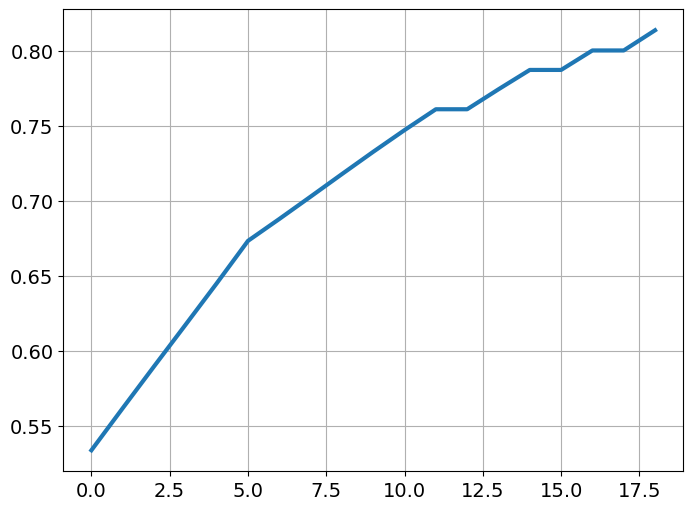

In [40]:
plt.plot(spolplot)

In [16]:
len(store[cvar][side]["crel"])

100

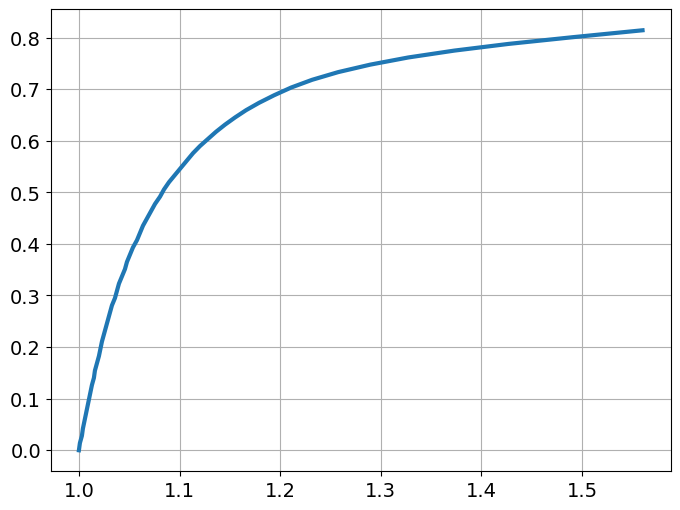

In [20]:
plt.plot(1/o["crel"], o["SpolPlot"])

In [13]:
len(crel)

2